TODO
1 Transfer learning with XCeption
1,2 Validate different Transfer Learning
2 Fine tuning with XCeption
3 

In [2]:
# Fix randomness and hide warnings
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
import cv2
from tensorflow.keras.applications.xception import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from DataLoader import load_data

In [5]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = load_data()
X_train.shape

(3328, 96, 96, 3)

In [7]:
batch_size = 32
epochs = 20


In [8]:
data_augmentation = tfk.Sequential([
    tfkl.experimental.preprocessing.RandomFlip("horizontal"),
    tfkl.experimental.preprocessing.RandomRotation(0.1),
])

In [9]:
model = tfk.applications.Xception(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
)

In [14]:
model.trainable = False

inputs = tfk.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)

norm_layer = tfkl.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2


x = norm_layer(x)
norm_layer.set_weights([mean, var, 0])

x = model(inputs, training=False)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.2)(x)
output = tfkl.Dense(1)(x)
tl_model = tfk.Model(inputs, output, name="modelX")
tl_model.compile(loss=tfk.losses.BinaryCrossentropy(from_logits=True), optimizer=tfk.optimizers.Adam(), metrics=[tfk.metrics.BinaryAccuracy()])
tl_model.summary()

Model: "modelX"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20863529 (79.59 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________

In [15]:
# Train the model
tl_history = tl_model.fit(
    x = X_train, # We need to apply the preprocessing
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/20
104/104 [==============================] - 14s 74ms/step - loss: 1.9072 - binary_accuracy: 0.5847 - val_loss: 1.1950 - val_binary_accuracy: 0.6250
Epoch 2/20
104/104 [==============================] - 6s 61ms/step - loss: 1.5295 - binary_accuracy: 0.6034 - val_loss: 0.8653 - val_binary_accuracy: 0.6334
Epoch 3/20
104/104 [==============================] - 7s 64ms/step - loss: 1.2880 - binary_accuracy: 0.6223 - val_loss: 1.0249 - val_binary_accuracy: 0.6490
Epoch 4/20
104/104 [==============================] - 6s 62ms/step - loss: 1.0900 - binary_accuracy: 0.6247 - val_loss: 0.7649 - val_binary_accuracy: 0.6358
Epoch 5/20
104/104 [==============================] - 7s 66ms/step - loss: 0.8864 - binary_accuracy: 0.6572 - val_loss: 0.7758 - val_binary_accuracy: 0.6382
Epoch 6/20
104/104 [==============================] - 6s 62ms/step - loss: 0.8802 - binary_accuracy: 0.6541 - val_loss: 0.8548 - val_binary_accuracy: 0.6370
Epoch 7/20
104/104 [==============================] - 8s 

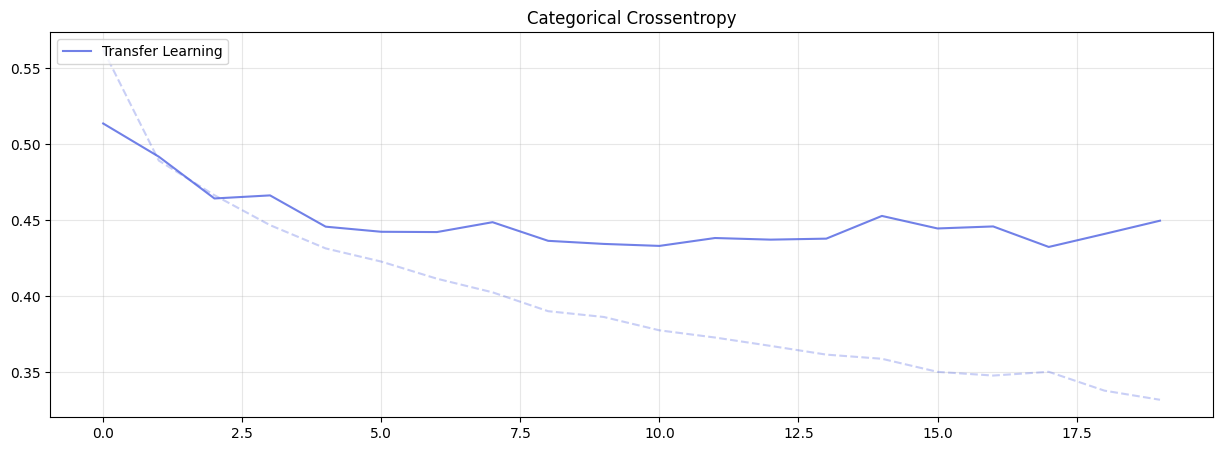

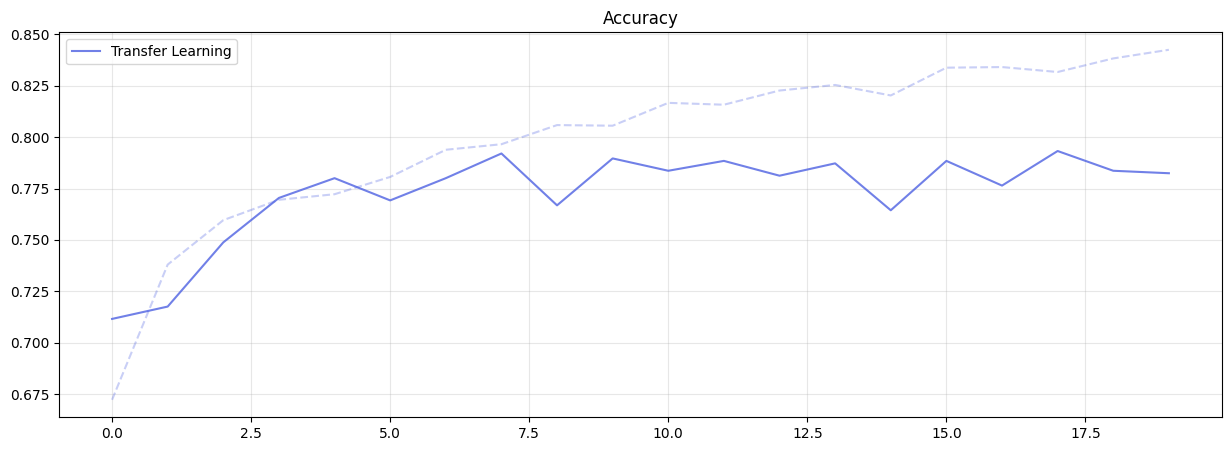

In [11]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['binary_accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_binary_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [12]:
# Save the best model
tl_model.save('XCeptionTransferLearning')
del tl_model

In [13]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('XCeptionTransferLearning')
ft_model.summary()

Model: "modelX"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 20863529 (79.59 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [17]:
def setup_model(model, trainable):
    # Freeze the un-trainable layers of the model base
    for layer in model.layers[:(len(model.layers) - trainable)]:
        layer.trainable = False

    for layer in model.layers[(len(model.layers) - trainable):]:
        layer.trainable = True

    model.compile(
        loss=tfk.losses.BinaryCrossentropy(),
        optimizer=tfk.optimizers.Adam(1e-5),
        metrics=['binary_accuracy']
    )

In [18]:
setup_model(ft_model, 19)
ft_model.summary()

Model: "modelX"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 20863529 (79.59 MB)
Trainable params: 20809001 (79.38 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________
